In [1]:
import quairkit as qkit
from quairkit import Circuit
from quairkit.qinfo import *
from quairkit.database import *
import numpy as np
import torch

qkit.set_dtype('complex128')

## Generate 4-call protocol in Theorem 1

Generate gates on the ancilla system

In [2]:
o_nz = torch.tensor([[-1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]], dtype=torch.complex128)

ft3 = torch.tensor([[0, 1, 1, 1],
                    [1, 0, 1, -1],
                    [1, -1, 0, 1],
                    [1, 1, -1, 0]], dtype=torch.complex128) / np.sqrt(3)

proj_zero = torch.kron(zero_state(1).bra, torch.eye(2 ** 3))

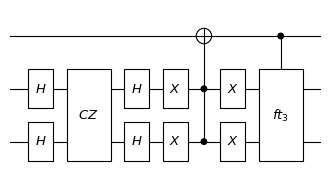

In [3]:
cir = Circuit(3)
cir.h([1, 2])
cir.oracle(o_nz, [1, 2], latex_name=r'$CZ$')
cir.h([1, 2])

cir.x([1, 2])
cir.ccx([2, 1, 0])
cir.x([1, 2])

cir.control_oracle(ft3, qubits_idx=[0, 1, 2], latex_name=r'$ft_3$')
cir.plot()

G2 = cir.unitary_matrix()
    

Construct circuit, where $U_\textrm{in}$ is randomly generated

In [4]:
Uin = random_unitary(1) * np.exp(1j * np.random.rand())

In [5]:
cir = Circuit(4)

cir.h([1, 2])

for i in range(4):
    cir.cx([2, 3])
    cir.cy([1, 3])
    cir.oracle(Uin, [3], latex_name=r'$U_{\text{in}}$')
    cir.cy([1, 3])
    cir.cx([2, 3])
    
    if i == 2:
        cir.oracle(o_nz, [1, 2], latex_name=r'$CZ$')
    
    if i in [0, 2]:
        cir.oracle(G2, qubits_idx=[0, 1, 2], latex_name=r'$G_2$')
        cir.x([0])
        
    elif i in [1, 3]:
        cir.oracle(G2.conj().T, qubits_idx=[0, 1, 2], latex_name=r'$G_2^\dagger$')

cir.h([1, 2])
cir.cy([2, 3])
cir.cx([1, 3])

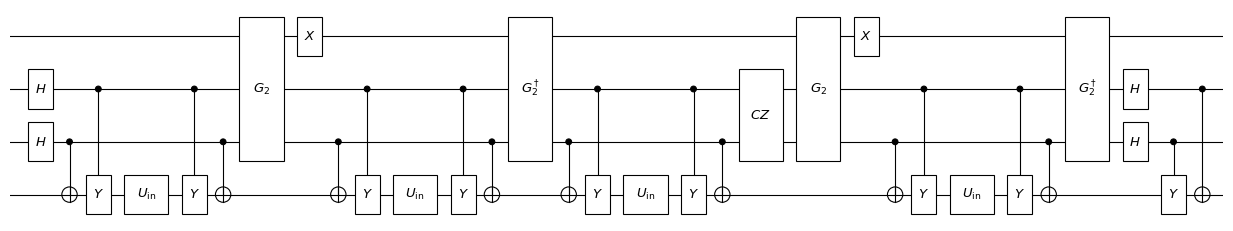

In [6]:
cir.plot()

## Verify

test this circuit by randomly input a qubit state $\rho$.

In [ ]:
rho = random_state(1)
input_state = qkit.to_state(torch.kron(zero_state(3).density_matrix, rho.density_matrix))
output_state = cir(input_state)

output_state = proj_zero @ output_state.density_matrix @ dagger(proj_zero)
print('The probability of the output state of the first qubit being |0> is', output_state.trace().item())
traced_state = partial_trace(output_state, [0, 1])

state_fidelity(dagger(Uin) @ rho.density_matrix @ Uin, traced_state).item()

The probability of the output state of the first qubit being |0> is (1.000000000000004-4.85722573273506e-17j)


1.0000000044179023